In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
%matplotlib inline
import torch
import torch.nn as nn

from nabstab.utils import load_model, AA2INDEX
from nabstab.datasets.classifier_dataset import pad_cdr2, pad_internal

In [2]:
from pathlib import Path
if '__file__' in globals():
    current_dir = Path(__file__).resolve().parent
else:
    current_dir = Path.cwd()

data_dir = current_dir.parent / 'data'
checkpoints_dir = current_dir.parent / 'model_checkpoints'

In [5]:
df = pd.read_csv(data_dir / 'natural_nb_data/naive_seqs.csv')

In [6]:
df['cdr12'] = df.CDR1 + df.CDR2
df = df.drop_duplicates(subset=['cdr12'], ignore_index=True)
df['cdr2_padded'] = df.CDR2.apply(pad_cdr2)
df['cdr3_padded'] = df.CDR3.apply(lambda x: pad_internal(x, 28))
df['padded_sequence'] = df.CDR1 + df.cdr2_padded + df.cdr3_padded

In [7]:
lr_checkpoint = checkpoints_dir / 'LR/20231223_LR.pt'
cnn_checkpoint = checkpoints_dir / 'CNN/cnn_24_fc_8.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#load models
lrmodel = load_model(
    checkpoint_path=lr_checkpoint,
    model_type='lr',
    device=device
)

cnnmodel = load_model(
    checkpoint_path=cnn_checkpoint,
    model_type='cnn',
    device=device
)

In [8]:
numseqs = torch.vstack([torch.tensor([AA2INDEX.get(aa, 20) for aa in seq], dtype=torch.long) for seq in df.padded_sequence.values])
batch_size = 1024

#split numseqs into batches, and predict using model
preds_lr = []
preds_cnn = []
for i in tqdm(range(0, numseqs.shape[0], batch_size)):
    batch = numseqs[i:i+batch_size].to(device)
    with torch.no_grad():
        preds_lr.append(lrmodel.predict(batch, return_logits=True))
        preds_cnn.append(cnnmodel.predict(batch, return_logits=True))

lr_preds = np.vstack(preds_lr)
cnn_preds = np.vstack(preds_cnn)

100%|██████████| 165/165 [00:09<00:00, 17.90it/s]


In [9]:
df['LR'] = lr_preds
df['CNN'] = cnn_preds

Text(0.5, 1.0, 'CNN Predictions')

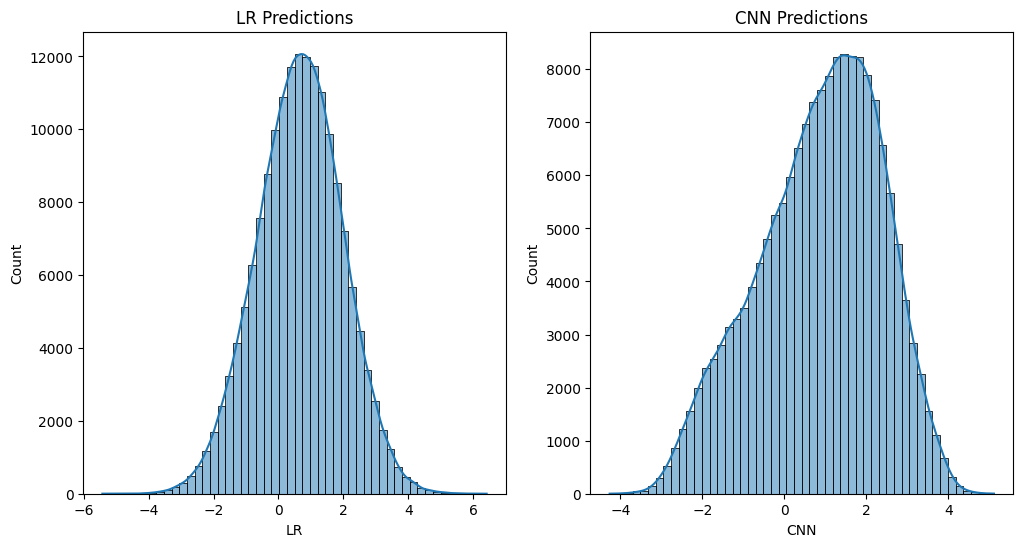

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(data=df, x='LR', bins=50, kde=True, ax=axs[0])

sns.histplot(data=df, x='CNN', bins=50, kde=True, ax=axs[1])

axs[0].set_title('LR Predictions')
axs[1].set_title('CNN Predictions')

In [15]:
df = df.sort_values(by='CNN', ascending=False)
df.tail(20000)

,idx,sequence,CDR1,CDR2,CDR3,cdr12,cdr2_padded,cdr3_padded,padded_sequence,LR,CNN
79658,459721,EVQLVESGGGLVQPGGSLRLSCAASGFTFDDYAIGWFRQAPGKERE...,FTFDDYA,GVSAISWNGGVTY,NARIYLLRIHDY,FTFDDYAGVSAISWNGGVTY,GVSAISWNGGVTY,NARIYL----------------LRIHDY,FTFDDYAGVSAISWNGGVTYNARIYL----------------LRIHDY,-0.427534,-1.122128
161366,1159855,EVQLVESGGGLVQPGGSLRLSCAASGTIFTINVMGWYRQAPGKGLE...,TIFTINV,WVSVINTGGGSTY,AAEIGPVGCSSWYDEYEY,TIFTINVWVSVINTGGGSTY,WVSVINTGGGSTY,AAEIGPVGC----------SSWYDEYEY,TIFTINVWVSVINTGGGSTYAAEIGPVGC----------SSWYDEYEY,-1.069391,-1.122178
42792,208574,EVQLVESGGGLVQAGGSLRLSCAASGIIFSFNDVGWYRQAAGKQRE...,IIFSFND,LVATITRGGGSTS,ATNRRGLLSLWVRKQVDY,IIFSFNDLVATITRGGGSTS,LVATITRGGGSTS,ATNRRGLLS----------LWVRKQVDY,IIFSFNDLVATITRGGGSTSATNRRGLLS----------LWVRKQVDY,-0.249922,-1.122304
66969,368342,EVQLVESGGGLVQPGGSLRLSCAASGTIFVINAMGWYRQAPGNQRE...,TIFVINA,LVATISSGGSTN,AVGLATIMSYSREYDY,TIFVINALVATISSGGSTN,LVATIS-SGGSTN,AVGLATIM------------SYSREYDY,TIFVINALVATIS-SGGSTNAVGLATIM------------SYSREYDY,-0.895005,-1.122315
28959,127955,EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYAMNWVRQAPGKGLE...,FTFSSYA,WVSAINICGGSTS,NADFGDLNPFEEYDY,FTFSSYAWVSAINICGGSTS,WVSAINICGGSTS,NADFGDL-------------NPFEEYDY,FTFSSYAWVSAINICGGSTSNADFGDL-------------NPFEEYDY,-1.374330,-1.122352
...,...,...,...,...,...,...,...,...,...,...,...
78839,453902,EVQLVESGGGLVQPGGSRRLSCAASGFIFRSYWMYWVRQAPGKGLE...,FIFRSYW,WVSVISWNGGSTN,NVDLWVWGNDY,FIFRSYWWVSVISWNGGSTN,WVSVISWNGGSTN,NVDLW-----------------VWGNDY,FIFRSYWWVSVISWNGGSTNNVDLW-----------------VWGNDY,-3.894001,-3.922288
34235,158104,EVQLVESGGGMVQPGGSLRLSCAASGSIFVINAMGWFRQAPGEERE...,SIFVINA,LVAAMHWRTRSAY,AALPTELLRLWVLWRMYDY,SIFVINALVAAMHWRTRSAY,LVAAMHWRTRSAY,AALPTELLR---------LWVLWRMYDY,SIFVINALVAAMHWRTRSAYAALPTELLR---------LWVLWRMYDY,-3.890117,-3.927623
82052,477817,EVQLVESGGGLVQPGGSLRLSCAASGSIFSIYAMGWFRQAPGKERG...,SIFSIYA,FVAVISWSGSSTY,NEWVVVITGLIMFDS,SIFSIYAFVAVISWSGSSTY,FVAVISWSGSSTY,NEWVVVI-------------TGLIMFDS,SIFSIYAFVAVISWSGSSTYNEWVVVI-------------TGLIMFDS,-5.423337,-4.079309
20236,81304,EVQLVESGGGLVQPGGSLRLSCAASGFTFSSYWMYWARQAPGKGLE...,FTFSSYW,WVSVISSGGGSTS,AKFTLVWSWYVGYDY,FTFSSYWWVSVISSGGGSTS,WVSVISSGGGSTS,AKFTLVW-------------SWYVGYDY,FTFSSYWWVSVISSGGGSTSAKFTLVW-------------SWYVGYDY,-3.200915,-4.113598


In [23]:
hist, bin_edges = np.histogram(df['CNN'], bins=50, density=True)

bin_middles = (bin_edges[:-1] + bin_edges[1:]) / 2

In [25]:
bin_middles.shape

(50,)

In [26]:
histogram_df = pd.DataFrame({
    'bin_middle': bin_middles,
    'frequency': hist
})

In [27]:
histogram_df.to_csv(data_dir / 'natural_nb_data/cnn_histogram.csv', index=False)

# Clustering

Cluster the top and bottom 20k by score. Within each group, find CDR1s and CDR2s that are unique to that group.

In [ ]:
from Levenshtein import distance as lev
from sklearn.cluster import AgglomerativeClustering
import sklearn

1.2.2


In [37]:
df = df.sort_values(by='CNN', ascending=False)

nseqs = 20000

top = df.head(nseqs)
bottom = df.tail(nseqs)

topseq = list(top.cdr12)
botseq = list(bottom.cdr12)
#all vs all distance
ava_top = np.zeros((nseqs, nseqs))
ava_bot = np.zeros((nseqs, nseqs))

for i in range(nseqs):
    for j in range(i+1, nseqs):
        ava_top[i,j] = lev(topseq[i], topseq[j])
        ava_bot[i,j] = lev(botseq[i], botseq[j])

ava_top = ava_top + ava_top.T
ava_bot = ava_bot + ava_bot.T

In [38]:
clustering1 = AgglomerativeClustering(n_clusters = None, metric='precomputed', linkage='single', distance_threshold=5)
clustering2 = AgglomerativeClustering(n_clusters = None, metric='precomputed', linkage='single', distance_threshold=5)
top_clusters = clustering1.fit(ava_top)
bot_clusters = clustering2.fit(ava_bot)

unique_top = np.unique(top_clusters.labels_)
unique_bot = np.unique(bot_clusters.labels_)

top_size = []
bot_size = []

for c in unique_top:
    top_size.append(np.sum(top_clusters.labels_ == c))
for c in unique_bot:
    bot_size.append(np.sum(bot_clusters.labels_ == c))

In [76]:
top_idx = top.index
bot_idx = bottom.index

index2cluster = {idx:top_clusters.labels_[i] for i, idx in enumerate(top_idx)}
index2cluster.update({idx:bot_clusters.labels_[i] for i, idx in enumerate(bot_idx)})
df['cluster'] = df.index.map(index2cluster, na_action='ignore')
subdf = df[~pd.isnull(df.cluster)]

In [77]:
high = subdf[subdf.CNN > 0]
high = high.sort_values(by = 'cluster')
low = subdf[subdf.CNN <= 0]
low = low.sort_values(by='cluster')

sampled_high_cdr1 = high.groupby('cluster').sample(1).CDR1.to_list()
sampled_high_cdr2 = high.groupby('cluster').sample(1).CDR2.to_list()
sampled_low_cdr1 = low.groupby('cluster').sample(1).CDR1.to_list()
sampled_low_cdr2 = low.groupby('cluster').sample(1).CDR2.to_list()

high_cdr1_uniques = set(sampled_high_cdr1).difference(set(sampled_low_cdr1))
high_cdr2_uniques = set(sampled_high_cdr2).difference(set(sampled_low_cdr2))
low_cdr1_uniques = set(sampled_low_cdr1).difference(set(sampled_high_cdr1))
low_cdr2_uniques = set(sampled_low_cdr2).difference(set(sampled_high_cdr2))

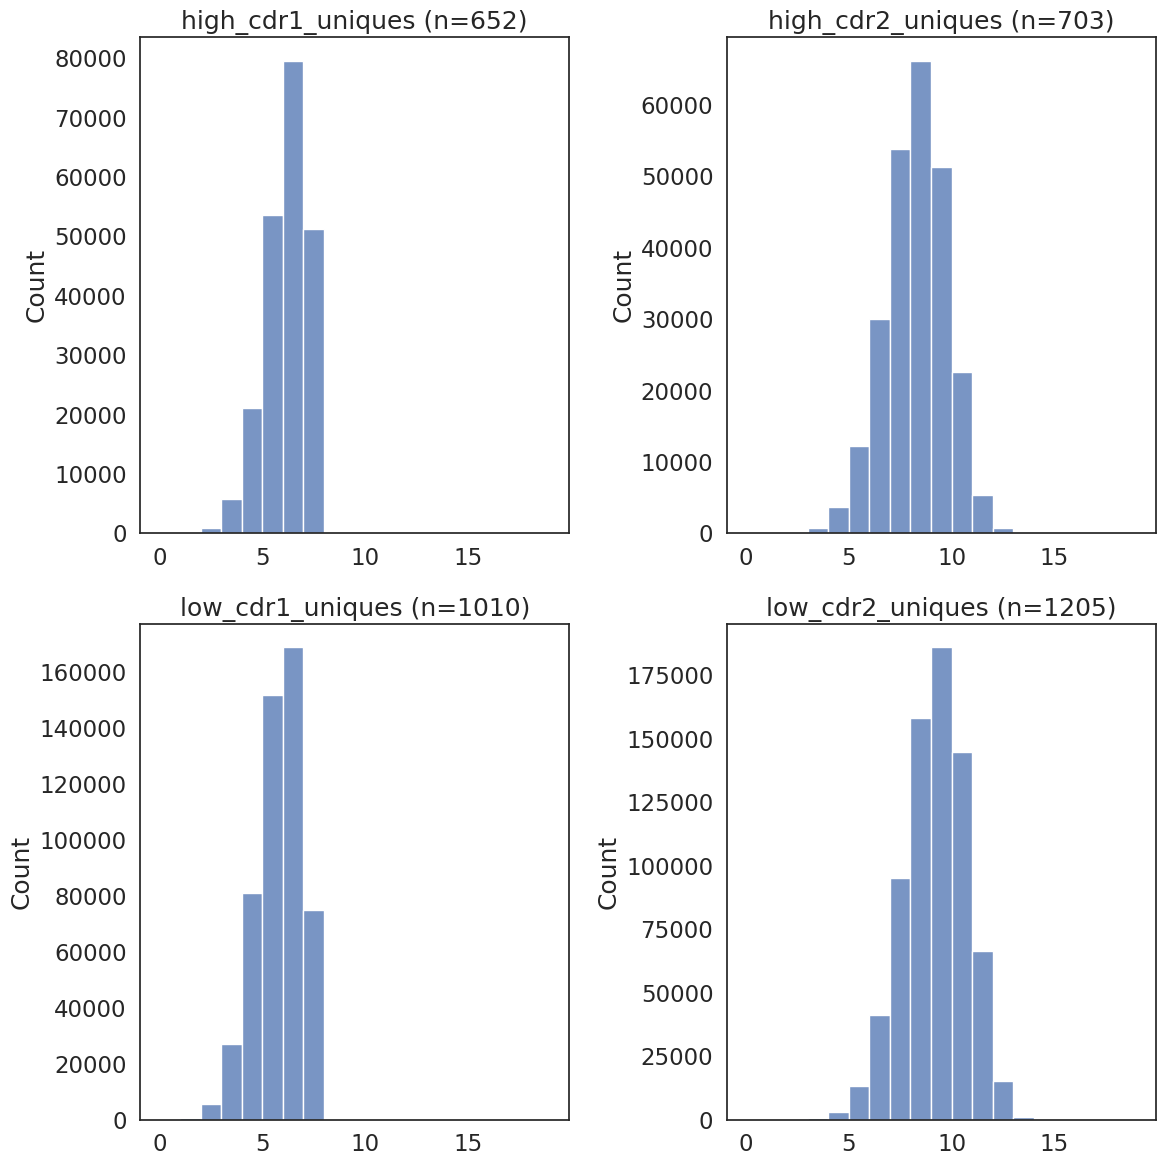

In [80]:
sets = ['high_cdr1_uniques', 'high_cdr2_uniques', 'low_cdr1_uniques', 'low_cdr2_uniques']

fig, axs = plt.subplots(2, 2, figsize=(12,12))

for i, s in enumerate(sets):
    ax = axs.ravel()[i]
    dists = np.zeros((len(eval(s)), len(eval(s))))
    seqs = list(eval(s))
    for ii in range(len(seqs)):
        for jj in range(ii+1, len(seqs)):
            dists[ii,jj] = lev(seqs[ii], seqs[jj])
    dists = dists + dists.T
    g1 = sns.histplot(dists[np.triu_indices_from(dists, k=1)], bins=np.arange(20), ax=ax)
    g1.set_title(f"{s} (n={len(seqs)})")
plt.tight_layout()

## Look at the generated sequences

In [68]:
import logomaker
import copy

In [59]:
# Function to convert hex to RGB (0-1 scale)
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) / 255 for i in (0, 2, 4))

# Updated Amino Acid to RGB Color Dictionary (0-1 scale)
aa_color_dict = {
    # Hydrophobic (Nonpolar) - Salomie
    'A': hex_to_rgb('fdd686'),  # Alanine
    'I': hex_to_rgb('fdd686'),  # Isoleucine
    'L': hex_to_rgb('fdd686'),  # Leucine
    'M': hex_to_rgb('fdd686'),  # Methionine
    'F': hex_to_rgb('fdd686'),  # Phenylalanine
    'W': hex_to_rgb('fdd686'),  # Tryptophan (switched with P)
    'V': hex_to_rgb('fdd686'),  # Valine
    
    # Positive - Danube
    'R': hex_to_rgb('6da0cd'),  # Arginine
    'H': hex_to_rgb('6da0cd'),  # Histidine
    'K': hex_to_rgb('6da0cd'),  # Lysine
    
    # Negative - Tapestry
    'D': hex_to_rgb('b25e7e'),  # Aspartic Acid
    'E': hex_to_rgb('b25e7e'),  # Glutamic Acid
    
    # Polar (Uncharged) - Fern
    'N': hex_to_rgb('5cb25d'),  # Asparagine
    'Q': hex_to_rgb('5cb25d'),  # Glutamine
    'S': hex_to_rgb('5cb25d'),  # Serine
    'T': hex_to_rgb('5cb25d'),  # Threonine
    
    # Special Cases
    'C': hex_to_rgb('af93d7'),  # Cysteine - Cold Purple
    'G': hex_to_rgb('E6ca51'),  # Glycine - Confetti
    'P': hex_to_rgb('af93d7'),  # Proline (switched with W) - Cold Purple
    'Y': hex_to_rgb('0f9015'),  # Tyrosine - La palma, slightly darker than Fern
}


# Logoplot of the saved CDRs

In [61]:
saved = {}
with open(current_dir / 'figure_4_outputs/designed_high_low_cdrs.txt', 'r') as f:
    for line in f:
        if '-' in line:
            key = line.split('-')[0].strip()
            saved[key] = []
        else:
            saved[key].append(line.strip())

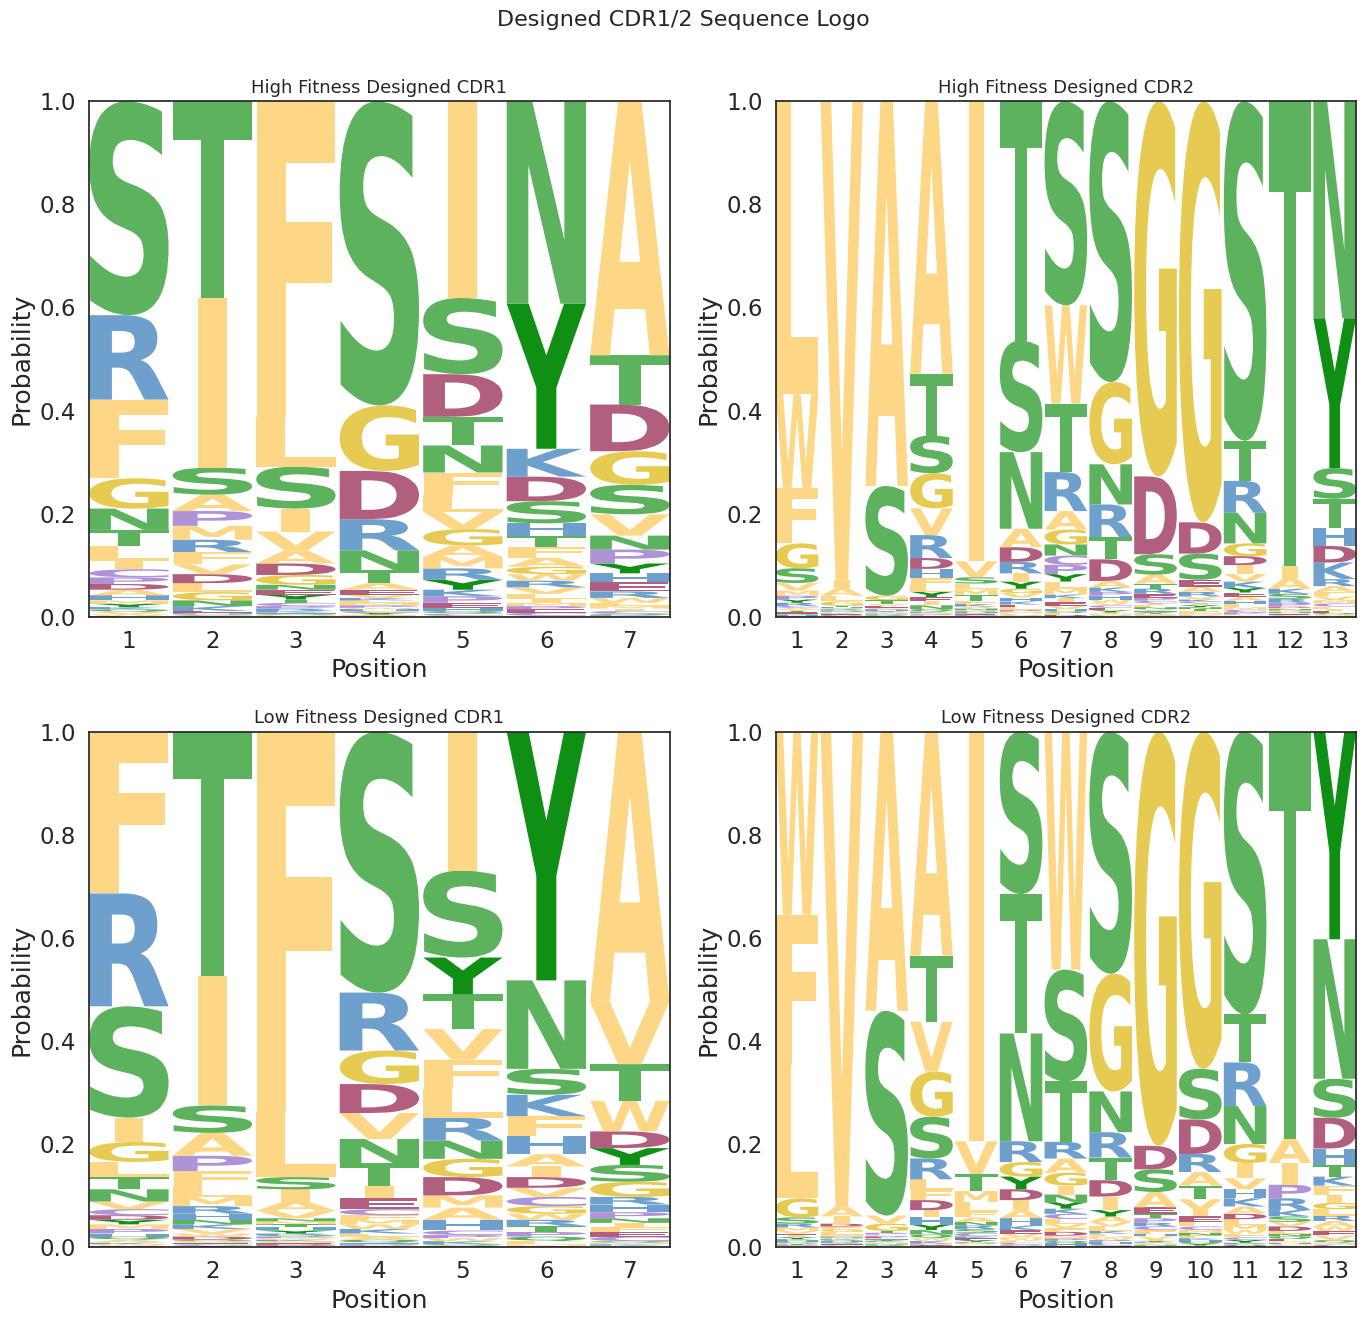

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(14,14))

sns.set_theme(style='white', font_scale=1.5)
for i,s in enumerate(saved.keys()):
    #v = list(eval(s))
    v = saved[s]
    ax = axs.ravel()[i]
    if 'cdr2' in s:
        #pad the sequences that are length 12 by adding '-' in middle
        v = [seq[:6] + '-' + seq[6:] if len(seq) == 12 else seq for seq in v]
    mat = logomaker.alignment_to_matrix(v, to_type='counts')
    pmat = logomaker.transform_matrix(mat, from_type='counts', to_type='probability')
    
    g1 = logomaker.Logo(pmat, ax=ax, color_scheme=aa_color_dict)

    #relabel the title

    if 'high' in s:
        name = 'High Fitness Designed'
    else:
        name = 'Low Fitness Designed'

    if 'cdr1' in s:
        name += ' CDR1'
    else:
        name += ' CDR2'

    g1.ax.set_title(name, fontsize=13)
    g1.ax.set_xticks(np.arange(0, len(v[0]), 1))
    g1.ax.set_xticklabels(np.arange(1, len(v[0])+1, 1))
    g1.ax.set_xlabel('Position')
    g1.ax.set_ylabel('Probability')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Designed CDR1/2 Sequence Logo', fontsize=16)

fig.savefig(current_dir / 'figure_4_outputs/nonclustered_sequence_logo.pdf')